# Merging events databases

In [97]:
import csv
import pandas as pd
import os
import numpy as np
import time
import datetime
import math
import re
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_circles, venn3

# Normalize

In [2]:
def intersection(lst1, lst2):
    lst1 = list(filter(None, lst1))
    lst2 = list(filter(None, lst2))
    if (len(lst1) and len(lst2)):
        lst3 = [value for value in lst1 if value in lst2] 
        if (len(lst3) > 0): 
            return True
        else:
            for i in lst1:
                for j in lst2:
                    if (i in j or j in i):
                        return j
            return False
    else:
        return False

In [3]:
def delete_duplicates(x):
    return list(dict.fromkeys(x))

In [4]:
codes = pd.read_csv('./country_codes.csv', error_bad_lines=False)
codes = codes[['name', 'alpha-3']]
codes.rename(columns={'name': 'country', 'alpha-3': 'country_code'}, inplace=True)
countries_list = list(codes['country'])

This is a manual normalization of country names since each source represent them in a different way

In [5]:
def normalize_country (country):
    final = ''
    if (country == 'Guatamala'):
        country = 'Guatemala'
    elif (country == 'USA' or country == 'Virgin Island (U.S.)'):
        country = 'United States of America'
    elif (country == 'Martinique' or country == 'Guadeloupe'):
        country = 'France'
    elif (country == 'Reunion' or country == 'R�union' or country == 'Saint Barth?lemy' or country == 'Saint Martin (French Part)'):
        country = 'France'
    elif (country == 'Kazakstan'):
        country = 'Kazakhstan'
    elif (country == 'Congo (the Democratic Republic of the)' or country == 'The Democratic Republic of the'):
        country = 'Congo Dem. Rep.'
    elif (country == 'Democratic Republic of Congo'):
        country = 'Congo Dem. Rep.'
    elif (country == 'Phillipines'):
        country = 'Philippines'
    elif (country == 'Unitd Kingdom' or country == 'Anguilla' or country == 'Virgin Island (British)'):
        country = 'United Kingdom'
    elif (country == 'Zimbawe'):
        country = 'Zimbabwe'
    elif (country == 'Taiwan'):
        country = 'China'
    elif (country == 'Macedonia (the former Yugoslav Republic of)'):
        country = 'North Macedonia'
    elif (country == 'Siwtzerland'):
        country = 'Switzerland'
    elif (country == 'East Timor'):
        country = 'Timor-Leste'   
    elif (country == "Cote d'Ivoire" or country == 'Ivory Coast' or country == 'C�te d�Ivoire'):
        country = "Côte d'Ivoire"
    elif (country == "Vietnam"):
        country = "Viet Nam"
    elif (country == "South Korea" or country == 'Korea (the Republic of)'):
        country = "Korea, Republic of"
    elif (country == "North Korea" or country == "Korea (the Democratic People's Republic of)"):
        country = "Korea (Democratic People's Republic of)"
    elif (country == "Laos"):
        country = "Lao People's Democratic Republic"
    elif (country == "Czech Republic (the)"):
        country = "Czechia"

    
    if (country in countries_list):
        return country
    else:
        inters = intersection([country], countries_list)
        if (inters != False):
            return inters
        else:
            print(country)
            unknown.append(country)
    return country

# EM-DAT

In [6]:
emdat = pd.read_csv('.data/databases/emdat.csv', error_bad_lines=False, encoding = "utf-8")

In [7]:
emdat.columns

Index(['Start date', 'End date', 'Country', 'ISO', 'Location', 'Latitude',
       'Longitude', 'Magnitude value', 'Magnitude scale', 'Disaster type',
       'Disaster subtype', 'Associated disaster', 'Total deaths',
       'Total affected', 'Total damage ('000 US$)',
       'Insured losses ('000 US$)', 'Disaster name', 'Disaster No.'],
      dtype='object')

In [8]:
emdat.rename(columns={"Start date": "start_date", "End date": "end_date", 'Country': 'country', 'Location': 'location_EMDAT', 'Disaster type': 'disaster_type', 'Disaster subtype': 'disaster_subtype', 'ISO': 'country_code', 'Disaster No.': 'identifier'}, inplace=True)

In [9]:
emdat.columns

Index(['start_date', 'end_date', 'country', 'country_code', 'location_EMDAT',
       'Latitude', 'Longitude', 'Magnitude value', 'Magnitude scale',
       'disaster_type', 'disaster_subtype', 'Associated disaster',
       'Total deaths', 'Total affected', 'Total damage ('000 US$)',
       'Insured losses ('000 US$)', 'Disaster name', 'identifier'],
      dtype='object')

In [10]:
emdat['start_date'] = pd.to_datetime(emdat['start_date'], format='%d/%m/%Y', errors='coerce')
emdat['end_date'] = pd.to_datetime(emdat['end_date'], format='%d/%m/%Y', errors='coerce')

In [11]:
affected = []
for index, row in emdat.iterrows():
    affected.append({'affected': row['Total affected'], 'fatalities': row['Total deaths']})

In [12]:
emdat['affected'] = affected

In [13]:
emdat.drop(columns=['Latitude', 'country_code', 'Longitude', 'Magnitude value', 'Magnitude scale', 'Associated disaster', "Total damage ('000 US$)", "Insured losses ('000 US$)", 'Disaster name', 'Total deaths', 'Total affected'], inplace=True)

In [14]:
identifiers = []
for index, row in emdat.iterrows():
    ids = {'emdatid': row['identifier'], 'flid': -1, 'dfoid': -1, 'emsid': -1}
    identifiers.append(ids)

In [15]:
emdat['identifier'] = identifiers
emdat['in_EMDAT'] = 1

In [16]:
unknown = []
emdat['country'] = emdat.country.apply(lambda x: normalize_country(x))

In [17]:
emdat = pd.merge(emdat, codes, on='country', how='left')

In [18]:
emdat.head()

,start_date,end_date,country,location_EMDAT,disaster_type,disaster_subtype,identifier,affected,in_EMDAT,country_code
0,2016-04-02,2016-04-08,Afghanistan,"Daykundi, Ghazni, Uruzgan provinces",Flood,Flash flood,"{'emdatid': '2016-0112', 'flid': -1, 'dfoid': ...","{'affected': 0, 'fatalities': 30}",1,AFG
1,2016-04-16,2016-04-17,Afghanistan,"Baghlan, Daykundi, Samangan, Takhar, Badghis p...",Flood,Flash flood,"{'emdatid': '2016-0135', 'flid': -1, 'dfoid': ...","{'affected': 0, 'fatalities': 31}",1,AFG
2,2016-05-09,2016-05-12,Afghanistan,"Badakhshan (Tashkan, Baharak, Darayem, Shahada...",Flood,--,"{'emdatid': '2016-0191', 'flid': -1, 'dfoid': ...","{'affected': 0, 'fatalities': 6}",1,AFG
3,2016-07-19,2016-07-19,Afghanistan,"Yaqubi, Haroonkhel districts (Khost city); Zaz...",Flood,--,"{'emdatid': '2016-0309', 'flid': -1, 'dfoid': ...","{'affected': 0, 'fatalities': 17}",1,AFG
4,2017-01-24,2017-01-25,Afghanistan,"Darzab district (Jawzjan province); Bamyan, Sh...",Storm,Convective storm,"{'emdatid': '2017-0038', 'flid': -1, 'dfoid': ...","{'affected': 0, 'fatalities': 31}",1,AFG


# FLOODLIST

In [19]:
floodlist = pd.read_csv('.data/databases/floodlist.csv', error_bad_lines=False)

In [20]:
floodlist.head()

,start_date,countries,damages,end_date,id_floodlist,locations,rainfall_level,type,in_floodlist
0,2019-07-10,Mexico,"[{'title': 'Fatalities', 'amount': '7', 'unit'...",2019-07-12,http://floodlist.com/america/mexico-landslide-...,"[{'title': 'Santo Tomás Chautla', 'longitude':...","[{'title': 'Rainfall level', 'amount': '62.9',...",Landslide,1
1,2019-07-07,Pakistan,"[{'title': 'Rescued', 'amount': '65', 'unit': ...",2019-07-09,http://floodlist.com/asia/pakistan-glacial-lak...,"[{'title': 'Golen', 'longitude': '72.268577400...",[],Glacial Lake Outburst Flood,1
2,2019-07-10,United States,"[{'title': 'Evacuated', 'amount': '10,000', 'u...",NaN,http://floodlist.com/america/usa/usa-louisiana...,"[{'title': 'New Orleans,=', 'longitude': '-90....","[{'title': 'Rainfall level', 'amount': '152.4'...","Urban flood, Flash flood",1
3,2019-07-08,United States,"[{'title': 'Rescued', 'amount': '100', 'unit':...",2019-07-12,http://floodlist.com/america/usa/flood-rescues...,"[{'title': 'Washington D.C', 'longitude': '-77...","[{'title': 'Rainfall level', 'amount': '101.85...","Flash flood, Landslide",1
4,2019-07-08,Spain,"[{'title': 'Fatalities', 'amount': '1', 'unit'...",2019-07-09,http://floodlist.com/europe/spain-flash-floods...,"[{'title': 'Tafalla', 'longitude': '-1.6776783...","[{'title': 'Rainfall level', 'amount': '100.2'...",Flash flood,1


In [21]:
floodlist['start_date'] = pd.to_datetime(floodlist['start_date'], format='%Y-%m-%d', errors='coerce')
floodlist['end_date'] = pd.to_datetime(floodlist['end_date'], format='%Y-%m-%d', errors='coerce')

In [22]:
floodlistdict = floodlist.to_dict('index')
new_dictionary = {}
index = 0

for flood in floodlistdict:
    try:
        countries = floodlistdict[flood]['countries']
        countries = countries.split(', ')
        for country in countries:
            temp = floodlistdict[flood].copy()
            temp['countries'] = country
            new_dictionary[index] = temp.copy()
            index+=1
    except:
        pass

In [23]:
floodlist=pd.DataFrame.from_dict(new_dictionary, orient='index')

In [24]:
floodlist.head()

,start_date,countries,damages,end_date,id_floodlist,locations,rainfall_level,type,in_floodlist
0,2019-07-10,Mexico,"[{'title': 'Fatalities', 'amount': '7', 'unit'...",2019-07-12,http://floodlist.com/america/mexico-landslide-...,"[{'title': 'Santo Tomás Chautla', 'longitude':...","[{'title': 'Rainfall level', 'amount': '62.9',...",Landslide,1
1,2019-07-07,Pakistan,"[{'title': 'Rescued', 'amount': '65', 'unit': ...",2019-07-09,http://floodlist.com/asia/pakistan-glacial-lak...,"[{'title': 'Golen', 'longitude': '72.268577400...",[],Glacial Lake Outburst Flood,1
2,2019-07-10,United States,"[{'title': 'Evacuated', 'amount': '10,000', 'u...",NaT,http://floodlist.com/america/usa/usa-louisiana...,"[{'title': 'New Orleans,=', 'longitude': '-90....","[{'title': 'Rainfall level', 'amount': '152.4'...","Urban flood, Flash flood",1
3,2019-07-08,United States,"[{'title': 'Rescued', 'amount': '100', 'unit':...",2019-07-12,http://floodlist.com/america/usa/flood-rescues...,"[{'title': 'Washington D.C', 'longitude': '-77...","[{'title': 'Rainfall level', 'amount': '101.85...","Flash flood, Landslide",1
4,2019-07-08,Spain,"[{'title': 'Fatalities', 'amount': '1', 'unit'...",2019-07-09,http://floodlist.com/europe/spain-flash-floods...,"[{'title': 'Tafalla', 'longitude': '-1.6776783...","[{'title': 'Rainfall level', 'amount': '100.2'...",Flash flood,1


In [25]:
floodlist.rename(columns={'damages': 'affected', 'countries': 'country', 'locations': 'location_Floodlist', 'type': 'disaster_type',  'id_floodlist': 'identifier'}, inplace=True)

In [26]:
def extract_fatalities (damages):
    if (type(damages) is str):
        if ('Fatalities' in damages):
            f = re.findall("'Fatalities', 'amount': '(.+?)'", damages)
            fatalities = 0
            for x in f:
                fatalities += int(x.replace(',', ''))
            return fatalities
    return 0

In [27]:
def extract_rescued_evacuated (damages):
    if (type(damages) is str):
        if ('Rescued' in damages or 'Evacuated' in damages or 'Affected' in damages):
            f = re.findall("('Rescued'|'Evacuated'|'Affected'), 'amount': '(.+?)'", damages)
            affected = 0
            for x in f:
                x_parsed = x[1].replace(',', '')
                x_parsed = x_parsed.replace(' ', '')
                x_parsed = x_parsed.replace('.', '')
                x_parsed = x_parsed.replace('million', '000000')
                affected += int(x_parsed)
            return affected
    return 0

In [28]:
affected = []

for index, row in floodlist.iterrows():
    fatalities = extract_fatalities(row['affected'])
    affect = extract_rescued_evacuated(row['affected'])
    affected.append({'affected': affect, 'fatalities': fatalities})

In [29]:
affected[13]

{'affected': 800, 'fatalities': 0}

In [30]:
floodlist['affected'] = affected

In [31]:
floodlist.drop(columns=['rainfall_level'], inplace=True)
identifiers = []
for index, row in floodlist.iterrows():
    ids = {'emdatid': -1, 'flid': row['identifier'], 'dfoid': -1, 'emsid': -1}
    identifiers.append(ids)
floodlist['identifier'] = identifiers

In [32]:
floodlist.head()

,start_date,country,affected,end_date,identifier,location_Floodlist,disaster_type,in_floodlist
0,2019-07-10,Mexico,"{'affected': 0, 'fatalities': 7}",2019-07-12,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","[{'title': 'Santo Tomás Chautla', 'longitude':...",Landslide,1
1,2019-07-07,Pakistan,"{'affected': 65, 'fatalities': 0}",2019-07-09,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","[{'title': 'Golen', 'longitude': '72.268577400...",Glacial Lake Outburst Flood,1
2,2019-07-10,United States,"{'affected': 10000, 'fatalities': 0}",NaT,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","[{'title': 'New Orleans,=', 'longitude': '-90....","Urban flood, Flash flood",1
3,2019-07-08,United States,"{'affected': 100, 'fatalities': 2}",2019-07-12,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","[{'title': 'Washington D.C', 'longitude': '-77...","Flash flood, Landslide",1
4,2019-07-08,Spain,"{'affected': 0, 'fatalities': 1}",2019-07-09,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","[{'title': 'Tafalla', 'longitude': '-1.6776783...",Flash flood,1


In [33]:
floodlist.shape

(1059, 8)

In [34]:
unknown = []
floodlist['country'] = floodlist.country.apply(lambda x: normalize_country(x))

In [35]:
floodlist = pd.merge(floodlist, codes, on='country', how='left')

In [36]:
floodlist.head()

,start_date,country,affected,end_date,identifier,location_Floodlist,disaster_type,in_floodlist,country_code
0,2019-07-10,Mexico,"{'affected': 0, 'fatalities': 7}",2019-07-12,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","[{'title': 'Santo Tomás Chautla', 'longitude':...",Landslide,1,MEX
1,2019-07-07,Pakistan,"{'affected': 65, 'fatalities': 0}",2019-07-09,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","[{'title': 'Golen', 'longitude': '72.268577400...",Glacial Lake Outburst Flood,1,PAK
2,2019-07-10,United States of America,"{'affected': 10000, 'fatalities': 0}",NaT,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","[{'title': 'New Orleans,=', 'longitude': '-90....","Urban flood, Flash flood",1,USA
3,2019-07-08,United States of America,"{'affected': 100, 'fatalities': 2}",2019-07-12,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","[{'title': 'Washington D.C', 'longitude': '-77...","Flash flood, Landslide",1,USA
4,2019-07-08,Spain,"{'affected': 0, 'fatalities': 1}",2019-07-09,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","[{'title': 'Tafalla', 'longitude': '-1.6776783...",Flash flood,1,ESP


In [37]:
floodlist = floodlist[floodlist['disaster_type'] != 'Landslide']

# DARTMOUTH

In [38]:
dartmouth = pd.read_csv('.data/databases/dartmouth.csv', error_bad_lines=False)

In [39]:
dartmouth.head()

,start_date,id_darmouth,countries,long,lat,area,end_date,deaths,affected,cause,in_darmouth
0,2016-02-28,4335,Bolivia,-64.9290,-12.8430,190581.43,2016-03-10,0,120,Heavy Rain,1
1,2016-03-01,4333,Angola,16.0564,-11.5936,277015.44,2016-03-10,30,1544,Heavy Rain,1
2,2016-03-05,4336,USA,-122.2840,38.6065,74128.03,2016-03-10,1,36,Heavy Rain,1
3,2016-03-05,4340,Argentina,-63.1227,-28.5633,199290.00,2016-03-25,0,1600,Heavy Rain,1
4,2016-03-06,4334,Serbia,21.0546,44.6710,16442.45,2016-03-10,0,420,Heavy Rain,1


In [40]:
dartmouth['start_date'] = pd.to_datetime(dartmouth['start_date'], format='%Y-%m-%d', errors='coerce')
dartmouth['end_date'] = pd.to_datetime(dartmouth['end_date'], format='%Y-%m-%d', errors='coerce')

In [41]:
dartmouthdict = dartmouth.to_dict('index')
new_dictionary = {}
index = 0

for flood in dartmouthdict:
    try:
        countries = dartmouthdict[flood]['countries']
        countries = countries.split(', ')
        for country in countries:
            temp = dartmouthdict[flood].copy()
            temp['countries'] = country
            new_dictionary[index] = temp.copy()
            index+=1
    except:
        pass

In [42]:
dartmouth=pd.DataFrame.from_dict(new_dictionary, orient='index')

In [43]:
dartmouth.rename(columns={'countries': 'country'}, inplace=True)

In [44]:
unknown = []
dartmouth['country'] = dartmouth.country.apply(lambda x: normalize_country(x))

In [45]:
dartmouth = pd.merge(dartmouth, codes, on='country', how='left')

In [46]:
affected = []
for index, row in dartmouth.iterrows():
    affected.append({'affected': row['affected'], 'fatalities': row['deaths']})

dartmouth['affected'] = affected

In [47]:
identifiers = []
for index, row in dartmouth.iterrows():
    ids = {'emdatid': -1, 'flid': -1, 'dfoid': row['id_darmouth'], 'emsid': -1}
    identifiers.append(ids)
dartmouth['identifier'] = identifiers

In [48]:
dartmouth.drop(columns=['long', 'lat', 'area', 'deaths', 'cause', 'id_darmouth'], inplace=True, errors='ignore')
dartmouth['disaster_type'] = 'Flood'

In [49]:
dartmouth.head()

,start_date,country,end_date,affected,in_darmouth,country_code,identifier,disaster_type
0,2016-02-28,Bolivia (Plurinational State of),2016-03-10,"{'affected': 120, 'fatalities': 0}",1,BOL,"{'emdatid': -1, 'flid': -1, 'dfoid': 4335, 'em...",Flood
1,2016-03-01,Angola,2016-03-10,"{'affected': 1544, 'fatalities': 30}",1,AGO,"{'emdatid': -1, 'flid': -1, 'dfoid': 4333, 'em...",Flood
2,2016-03-05,United States of America,2016-03-10,"{'affected': 36, 'fatalities': 1}",1,USA,"{'emdatid': -1, 'flid': -1, 'dfoid': 4336, 'em...",Flood
3,2016-03-05,Argentina,2016-03-25,"{'affected': 1600, 'fatalities': 0}",1,ARG,"{'emdatid': -1, 'flid': -1, 'dfoid': 4340, 'em...",Flood
4,2016-03-06,Serbia,2016-03-10,"{'affected': 420, 'fatalities': 0}",1,SRB,"{'emdatid': -1, 'flid': -1, 'dfoid': 4334, 'em...",Flood


# EMS

In [50]:
ems = pd.read_csv('.data/databases/ems.csv', error_bad_lines=False)

In [51]:
ems.head()

,start_date,id_EMS,area,countries,type,in_EMS
0,2016-03-04,https://emergency.copernicus.eu/mapping/list-o...,Roscommon County,Ireland,Flood,1
1,2016-05-11,https://emergency.copernicus.eu/mapping/list-o...,Rudaki district,Tajikistan,Flood,1
2,2016-05-30,https://emergency.copernicus.eu/mapping/list-o...,"Loiret, central region",France,Flood,1
3,2016-06-01,https://emergency.copernicus.eu/mapping/list-o...,Lower Bavaria,Germany,Flood,1
4,2016-06-02,https://emergency.copernicus.eu/mapping/list-o...,Limburg Province,Belgium,Flood,1


In [52]:
ems['start_date'] = pd.to_datetime(ems['start_date'], format='%Y-%m-%d', errors='coerce')

In [53]:
emsdict = ems.to_dict('index')
new_dictionary = {}
index = 0

for flood in emsdict:
    try:
        countries = emsdict[flood]['countries']
        countries = countries.split(', ')
        for country in countries:
            temp = emsdict[flood].copy()
            temp['countries'] = country
            new_dictionary[index] = temp.copy()
            index+=1
    except:
        pass

In [54]:
ems=pd.DataFrame.from_dict(new_dictionary, orient='index')

In [55]:
ems['countries'] = ems.countries.apply(lambda x: normalize_country(x))

In [56]:
ems.rename(columns={'countries': 'country','type': 'disaster_type', 'area': 'location_EMS'}, inplace=True)

In [57]:
ems = pd.merge(ems, codes, on='country', how='left')

In [58]:
identifiers = []
for index, row in ems.iterrows():
    ids = {'emdatid': -1, 'flid': -1, 'dfoid': -1, 'emsid': row['id_EMS']}
    identifiers.append(ids)
ems['identifier'] = identifiers

In [59]:
ems.head()

,start_date,id_EMS,location_EMS,country,disaster_type,in_EMS,country_code,identifier
0,2016-03-04,https://emergency.copernicus.eu/mapping/list-o...,Roscommon County,Ireland,Flood,1,IRL,"{'emdatid': -1, 'flid': -1, 'dfoid': -1, 'emsi..."
1,2016-05-11,https://emergency.copernicus.eu/mapping/list-o...,Rudaki district,Tajikistan,Flood,1,TJK,"{'emdatid': -1, 'flid': -1, 'dfoid': -1, 'emsi..."
2,2016-05-30,https://emergency.copernicus.eu/mapping/list-o...,"Loiret, central region",France,Flood,1,FRA,"{'emdatid': -1, 'flid': -1, 'dfoid': -1, 'emsi..."
3,2016-06-01,https://emergency.copernicus.eu/mapping/list-o...,Lower Bavaria,Germany,Flood,1,DEU,"{'emdatid': -1, 'flid': -1, 'dfoid': -1, 'emsi..."
4,2016-06-02,https://emergency.copernicus.eu/mapping/list-o...,Limburg Province,Belgium,Flood,1,BEL,"{'emdatid': -1, 'flid': -1, 'dfoid': -1, 'emsi..."


In [60]:
ems.drop(columns=['id_EMS'], inplace=True, errors='ignore')

In [61]:
ems.head()

,start_date,location_EMS,country,disaster_type,in_EMS,country_code,identifier
0,2016-03-04,Roscommon County,Ireland,Flood,1,IRL,"{'emdatid': -1, 'flid': -1, 'dfoid': -1, 'emsi..."
1,2016-05-11,Rudaki district,Tajikistan,Flood,1,TJK,"{'emdatid': -1, 'flid': -1, 'dfoid': -1, 'emsi..."
2,2016-05-30,"Loiret, central region",France,Flood,1,FRA,"{'emdatid': -1, 'flid': -1, 'dfoid': -1, 'emsi..."
3,2016-06-01,Lower Bavaria,Germany,Flood,1,DEU,"{'emdatid': -1, 'flid': -1, 'dfoid': -1, 'emsi..."
4,2016-06-02,Limburg Province,Belgium,Flood,1,BEL,"{'emdatid': -1, 'flid': -1, 'dfoid': -1, 'emsi..."


# ALL TABLES

In [62]:
floodlist.head(1)

,start_date,country,affected,end_date,identifier,location_Floodlist,disaster_type,in_floodlist,country_code
1,2019-07-07,Pakistan,"{'affected': 65, 'fatalities': 0}",2019-07-09,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","[{'title': 'Golen', 'longitude': '72.268577400...",Glacial Lake Outburst Flood,1,PAK


In [63]:
ems.head(1)

,start_date,location_EMS,country,disaster_type,in_EMS,country_code,identifier
0,2016-03-04,Roscommon County,Ireland,Flood,1,IRL,"{'emdatid': -1, 'flid': -1, 'dfoid': -1, 'emsi..."


In [64]:
dartmouth.head(1)

,start_date,country,end_date,affected,in_darmouth,country_code,identifier,disaster_type
0,2016-02-28,Bolivia (Plurinational State of),2016-03-10,"{'affected': 120, 'fatalities': 0}",1,BOL,"{'emdatid': -1, 'flid': -1, 'dfoid': 4335, 'em...",Flood


In [65]:
emdat.head(1)

,start_date,end_date,country,location_EMDAT,disaster_type,disaster_subtype,identifier,affected,in_EMDAT,country_code
0,2016-04-02,2016-04-08,Afghanistan,"Daykundi, Ghazni, Uruzgan provinces",Flood,Flash flood,"{'emdatid': '2016-0112', 'flid': -1, 'dfoid': ...","{'affected': 0, 'fatalities': 30}",1,AFG


# MERGE

In [66]:
merge = pd.concat([floodlist, emdat, ems, dartmouth], ignore_index=True, join='outer', sort=False)
merge.sort_values(by='start_date', inplace=True)
merge = merge.set_index('start_date').loc['2016-02-25':'2019-05-20'].reset_index(drop=False)
merge = merge[['start_date', 'end_date', 'country', 'country_code', 'affected', 'location_Floodlist', 'location_EMDAT', 'location_EMS', 'identifier', 'disaster_type', 'disaster_subtype', 'in_floodlist', 'in_EMS', 'in_EMDAT', 'in_darmouth']]
merge.head(100)

,start_date,end_date,country,country_code,affected,location_Floodlist,location_EMDAT,location_EMS,identifier,disaster_type,disaster_subtype,in_floodlist,in_EMS,in_EMDAT,in_darmouth
0,2016-02-25,2016-02-29,Peru,PER,"{'affected': 0, 'fatalities': 2}","[{'title': 'Piura Region, Peru', 'longitude': ...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","Inland flood, Landslide, River flood",NaN,1.0,NaN,NaN,NaN
1,2016-02-26,2016-03-01,Indonesia,IDN,"{'affected': 34000, 'fatalities': 1}","[{'title': 'Sampang, East Java, Indonesia', 'l...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","Inland flood, River flood",NaN,1.0,NaN,NaN,NaN
2,2016-02-27,2016-02-29,Jamaica,JAM,"{'affected': 1, 'fatalities': 0}","[{'title': 'St James Parish, Jamaica', 'longit...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...",Flash flood,NaN,1.0,NaN,NaN,NaN
3,2016-02-27,2016-02-28,Malaysia,MYS,"{'affected': 0, 'fatalities': 0}","[{'title': 'Kuching Malaysia', 'longitude': '1...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...",Flash flood,NaN,1.0,NaN,NaN,NaN
4,2016-02-28,2016-03-03,Bolivia (Plurinational State of),BOL,"{'affected': 120, 'fatalities': 0}",NaN,"Sur Yungas, Nor Yungas, Camacho, Bautista Saav...",NaN,"{'emdatid': '2016-0246', 'flid': -1, 'dfoid': ...",Flood,--,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2016-04-16,2016-04-22,Angola,AGO,"{'affected': 5600, 'fatalities': 23}",NaN,"Viana, Cacuaco, Belas (Viana), Cazenga and urb...",NaN,"{'emdatid': '2016-0131', 'flid': -1, 'dfoid': ...",Flood,Flash flood,NaN,NaN,1.0,NaN
96,2016-04-16,2016-04-22,Russian Federation,RUS,"{'affected': 3200, 'fatalities': 0}",NaN,"Vologodskaya Oblast, Tyumenskaya Oblast, Sverd...",NaN,"{'emdatid': '2016-0128', 'flid': -1, 'dfoid': ...",Flood,--,NaN,NaN,1.0,NaN
97,2016-04-16,2016-04-17,Afghanistan,AFG,"{'affected': 0, 'fatalities': 31}",NaN,"Baghlan, Daykundi, Samangan, Takhar, Badghis p...",NaN,"{'emdatid': '2016-0135', 'flid': -1, 'dfoid': ...",Flood,Flash flood,NaN,NaN,1.0,NaN
98,2016-04-16,2016-04-19,United States of America,USA,"{'affected': 21000, 'fatalities': 9}",NaN,"Fayette, Grimes, Harris, Parker counties, Hous...",NaN,"{'emdatid': '2016-0124', 'flid': -1, 'dfoid': ...",Flood,Flash flood,NaN,NaN,1.0,NaN


In [67]:
merge.shape

(2295, 15)

In [68]:
merge['duration'] = merge['end_date']-merge['start_date']

In [69]:
durations = merge['duration'].dropna().values

In [70]:
median = np.median(durations)
print(median)

345600000000000 nanoseconds


In [71]:
days = median.astype('timedelta64[D]')
print('Median is %.0f days' % (days / np.timedelta64(1, 'D')))

Median is 4 days


# GROUP FLOODS

In [72]:
def define_min_date(date1, date2):
    if (date1 <= date2):
        #print(date1)
        return date1
    elif (date2 < date1):
        #print(date2)
        return date2

In [73]:
def define_max_date(date1, date2):
    if (date1.year==2050):
        final = date2
    elif (date2.year==2050):
        final = date1
    elif (date1 >= date2):
        final = date1
    elif (date2 > date1):
        final = date2
    
    return final

In [74]:
merge['end_date'] = merge['end_date'].fillna(merge['start_date']+datetime.timedelta(days=4))

In [75]:
merge.head(50)

,start_date,end_date,country,country_code,affected,location_Floodlist,location_EMDAT,location_EMS,identifier,disaster_type,disaster_subtype,in_floodlist,in_EMS,in_EMDAT,in_darmouth,duration
0,2016-02-25,2016-02-29,Peru,PER,"{'affected': 0, 'fatalities': 2}","[{'title': 'Piura Region, Peru', 'longitude': ...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","Inland flood, Landslide, River flood",NaN,1.0,NaN,NaN,NaN,4 days
1,2016-02-26,2016-03-01,Indonesia,IDN,"{'affected': 34000, 'fatalities': 1}","[{'title': 'Sampang, East Java, Indonesia', 'l...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","Inland flood, River flood",NaN,1.0,NaN,NaN,NaN,4 days
2,2016-02-27,2016-02-29,Jamaica,JAM,"{'affected': 1, 'fatalities': 0}","[{'title': 'St James Parish, Jamaica', 'longit...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...",Flash flood,NaN,1.0,NaN,NaN,NaN,2 days
3,2016-02-27,2016-02-28,Malaysia,MYS,"{'affected': 0, 'fatalities': 0}","[{'title': 'Kuching Malaysia', 'longitude': '1...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...",Flash flood,NaN,1.0,NaN,NaN,NaN,1 days
4,2016-02-28,2016-03-03,Bolivia (Plurinational State of),BOL,"{'affected': 120, 'fatalities': 0}",NaN,"Sur Yungas, Nor Yungas, Camacho, Bautista Saav...",NaN,"{'emdatid': '2016-0246', 'flid': -1, 'dfoid': ...",Flood,--,NaN,NaN,1.0,NaN,4 days
5,2016-02-28,2016-03-03,Bolivia (Plurinational State of),BOL,"{'affected': 0, 'fatalities': 0}","[{'title': 'Apolo, La Paz, Bolivia', 'longitud...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","Inland flood, Landslide, River flood",NaN,1.0,NaN,NaN,NaN,4 days
6,2016-02-28,2016-03-01,Haiti,HTI,"{'affected': 0, 'fatalities': 1}","[{'title': ""Grand'Anse Department"", 'longitude...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...",Inland flood,NaN,1.0,NaN,NaN,NaN,2 days
7,2016-02-28,2016-02-28,Haiti,HTI,"{'affected': 48280, 'fatalities': 5}",NaN,"Cap-Haitien, Limonade cities (Cap Haitien dist...",NaN,"{'emdatid': '2016-0053', 'flid': -1, 'dfoid': ...",Flood,Riverine flood,NaN,NaN,1.0,NaN,0 days
8,2016-02-28,2016-03-10,Bolivia (Plurinational State of),BOL,"{'affected': 120, 'fatalities': 0}",NaN,NaN,NaN,"{'emdatid': -1, 'flid': -1, 'dfoid': 4335, 'em...",Flood,NaN,NaN,NaN,NaN,1.0,11 days
9,2016-02-29,2016-03-01,Angola,AGO,"{'affected': 0, 'fatalities': 29}","[{'title': 'Lubango, Huíla, Angola', 'longitud...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...",Flash flood,NaN,1.0,NaN,NaN,NaN,1 days


In [76]:
def overlap(start1, start2, end1, end2):
    first_int = [start1, end1]
    second_int = [start2, end2]
    
    for f,s in ((first_int,second_int), (second_int,first_int)):
        #will check both ways
        for date in s:
            if (f[0] <= date <= f[1]):
                return True
    return False

In [77]:
def check_origin (row1, row2):
    if (row1['in_darmouth'] == 1 and row2['in_darmouth'] == 1):
        return False
    elif (row1['in_EMDAT'] == 1 and row2['in_EMDAT'] == 1):
        return False
    elif (row1['in_EMS'] == 1 and row2['in_EMS'] == 1):
        return False
    elif (row1['in_floodlist'] == 1 and row2['in_floodlist'] == 1):
        return False
    
    return True

In [78]:
def define_affected_type (flood, flood2):
    final_dict = flood['affected']
    if (flood['in_EMDAT'] == 1):
        return flood['affected'], flood['disaster_type']
    elif(flood2['in_EMDAT'] == 1):
        return flood2['affected'], flood2['disaster_type']
    elif (flood['in_floodlist'] == 1):
        return flood['affected'], flood['disaster_type']
    elif (flood2['in_floodlist'] == 1):
        return flood2['affected'], flood2['disaster_type']
    elif (flood['in_darmouth'] == 1):
        return flood['affected'], flood['disaster_type']
    elif (flood2['in_darmouth'] == 1):
        return flood2['affected'], flood2['disaster_type']

In [79]:
def merge_identifiers(flood, flood2):
    merged = {'emdatid': -1, 'flid': -1, 'dfoid': -1, 'emsid': -1}
    for i in flood['identifier']:
        if (flood['identifier'][i] != -1):
            merged[i] = flood['identifier'][i]
            
    for i in flood2['identifier']:
        if (flood2['identifier'][i] != -1):
            merged[i] = flood2['identifier'][i]
            
    return merged

In [80]:
def merge_dictionaries(temp, flood2):
    for key in temp:
        if (pd.isnull(temp[key])):
            temp[key] = flood2[key]
    return temp

In [81]:
merge_dict = merge.to_dict('index')
grouped = {}

In [82]:
grouped_index = 0
dict_len = len(merge_dict.keys())

for index in range(dict_len):
    flood = merge_dict[index]
    if (flood['start_date'] != 'skip'):
        temp = flood.copy()

        for index2 in range(min(index+1, dict_len), min(index+500, dict_len)):
            flood2 = merge_dict[index2]
            if (flood2['start_date'] != 'skip'):
                if(temp['country'] == flood2['country']):
                    if (overlap(temp['start_date'], flood2['start_date'], temp['end_date'], flood2['end_date'])):
                        temp['start_date'] = define_min_date(temp['start_date'], flood2['start_date'])
                        temp['end_date'] = define_max_date(temp['end_date'], flood2['end_date'])
                        temp['affected'], temp['disaster_type'] = define_affected_type(temp,flood2)
                        temp['identifier'] = merge_identifiers(temp,flood2)
                        temp = merge_dictionaries(temp, flood2)

                        flood2['start_date'] = 'skip'
        
        grouped[grouped_index] = temp.copy()  
        grouped_index+=1

In [83]:
len(grouped)

1102

In [84]:
len(merge_dict)

2295

In [85]:
merge.head(60)

,start_date,end_date,country,country_code,affected,location_Floodlist,location_EMDAT,location_EMS,identifier,disaster_type,disaster_subtype,in_floodlist,in_EMS,in_EMDAT,in_darmouth,duration
0,2016-02-25,2016-02-29,Peru,PER,"{'affected': 0, 'fatalities': 2}","[{'title': 'Piura Region, Peru', 'longitude': ...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","Inland flood, Landslide, River flood",NaN,1.0,NaN,NaN,NaN,4 days
1,2016-02-26,2016-03-01,Indonesia,IDN,"{'affected': 34000, 'fatalities': 1}","[{'title': 'Sampang, East Java, Indonesia', 'l...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","Inland flood, River flood",NaN,1.0,NaN,NaN,NaN,4 days
2,2016-02-27,2016-02-29,Jamaica,JAM,"{'affected': 1, 'fatalities': 0}","[{'title': 'St James Parish, Jamaica', 'longit...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...",Flash flood,NaN,1.0,NaN,NaN,NaN,2 days
3,2016-02-27,2016-02-28,Malaysia,MYS,"{'affected': 0, 'fatalities': 0}","[{'title': 'Kuching Malaysia', 'longitude': '1...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...",Flash flood,NaN,1.0,NaN,NaN,NaN,1 days
4,2016-02-28,2016-03-03,Bolivia (Plurinational State of),BOL,"{'affected': 120, 'fatalities': 0}",NaN,"Sur Yungas, Nor Yungas, Camacho, Bautista Saav...",NaN,"{'emdatid': '2016-0246', 'flid': -1, 'dfoid': ...",Flood,--,NaN,NaN,1.0,NaN,4 days
5,2016-02-28,2016-03-03,Bolivia (Plurinational State of),BOL,"{'affected': 0, 'fatalities': 0}","[{'title': 'Apolo, La Paz, Bolivia', 'longitud...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","Inland flood, Landslide, River flood",NaN,1.0,NaN,NaN,NaN,4 days
6,2016-02-28,2016-03-01,Haiti,HTI,"{'affected': 0, 'fatalities': 1}","[{'title': ""Grand'Anse Department"", 'longitude...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...",Inland flood,NaN,1.0,NaN,NaN,NaN,2 days
7,2016-02-28,2016-02-28,Haiti,HTI,"{'affected': 48280, 'fatalities': 5}",NaN,"Cap-Haitien, Limonade cities (Cap Haitien dist...",NaN,"{'emdatid': '2016-0053', 'flid': -1, 'dfoid': ...",Flood,Riverine flood,NaN,NaN,1.0,NaN,0 days
8,2016-02-28,2016-03-10,Bolivia (Plurinational State of),BOL,"{'affected': 120, 'fatalities': 0}",NaN,NaN,NaN,"{'emdatid': -1, 'flid': -1, 'dfoid': 4335, 'em...",Flood,NaN,NaN,NaN,NaN,1.0,11 days
9,2016-02-29,2016-03-01,Angola,AGO,"{'affected': 0, 'fatalities': 29}","[{'title': 'Lubango, Huíla, Angola', 'longitud...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...",Flash flood,NaN,1.0,NaN,NaN,NaN,1 days


In [86]:
merge2 = pd.DataFrame.from_dict(grouped, orient='index')
merge2.tail(50)

,start_date,end_date,country,country_code,affected,location_Floodlist,location_EMDAT,location_EMS,identifier,disaster_type,disaster_subtype,in_floodlist,in_EMS,in_EMDAT,in_darmouth,duration
1052,2019-03-21,2019-03-25,Ecuador,ECU,"{'affected': 8250, 'fatalities': 0}","[{'title': 'Pueblo Viejo', 'longitude': '-79.5...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","Flash flood, River flood",NaN,1.0,NaN,NaN,NaN,NaT
1053,2019-03-23,2019-03-29,Burundi,BDI,"{'affected': 25, 'fatalities': 0}","[{'title': 'Mwumba', 'longitude': '29.80339700...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...",Flash flood,NaN,1.0,NaN,NaN,1.0,5 days
1054,2019-03-24,2019-04-02,Iraq,IRQ,"{'affected': 5865, 'fatalities': 10}",NaN,"Anbar, Basra, Dahuk, Diyala, Kirkuk, Missan, M...",NaN,"{'emdatid': '2019-0141', 'flid': -1, 'dfoid': ...",Flood,--,NaN,NaN,1.0,NaN,9 days
1055,2019-03-25,2019-03-29,New Zealand,NZL,"{'affected': 0, 'fatalities': 1}","[{'title': 'Franz Josef', 'longitude': '170.18...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...","Flash flood, Landslide, River flood",NaN,1.0,NaN,NaN,1.0,2 days
1056,2019-03-29,2019-04-02,Peru,PER,"{'affected': 150, 'fatalities': 0}",NaN,NaN,NaN,"{'emdatid': -1, 'flid': -1, 'dfoid': 4735, 'em...",Flood,NaN,NaN,NaN,NaN,1.0,4 days
1057,2019-03-30,2019-04-03,Syrian Arab Republic,SYR,"{'affected': 235000, 'fatalities': 2}",NaN,"Idleb, Al Hasakeh Governate",NaN,"{'emdatid': '2019-0137', 'flid': -1, 'dfoid': ...",Flood,--,NaN,NaN,1.0,NaN,4 days
1058,2019-03-30,2019-03-31,Nepal,NPL,"{'affected': 14854, 'fatalities': 28}",NaN,Bara district,NaN,"{'emdatid': '2019-0135', 'flid': -1, 'dfoid': ...",Storm,Convective storm,NaN,NaN,1.0,NaN,1 days
1059,2019-03-31,2019-03-31,Bangladesh,BGD,"{'affected': 0, 'fatalities': 15}",NaN,Dhaka,NaN,"{'emdatid': '2019-0144', 'flid': -1, 'dfoid': ...",Storm,Convective storm,NaN,NaN,1.0,NaN,0 days
1060,2019-04-01,2019-04-20,Colombia,COL,"{'affected': 1647, 'fatalities': 14}","[{'title': 'Vigía del Fuerte, Antioquia', 'lon...","Antioquia, Nari�o, Cauca, Cundinamarca, Huila,...",NaN,"{'emdatid': '2019-0159', 'flid': 'http://flood...",Flood,--,1.0,NaN,1.0,1.0,19 days
1061,2019-04-01,2019-04-05,Ghana,GHA,"{'affected': 500, 'fatalities': 12}","[{'title': 'Accra', 'longitude': '-0.186964399...",NaN,NaN,"{'emdatid': -1, 'flid': 'http://floodlist.com/...",Flash flood,NaN,1.0,NaN,NaN,NaN,NaT


# SELECT INTERSECTION

In [89]:
gt_dict = merge2.to_dict('index')

In [90]:
setfloodlist = set()
setemdat = set()
setdarmouth = set()
setems = set()

for flood in gt_dict:
    if gt_dict[flood]['in_floodlist'] == 1:
        setfloodlist.add(flood)
    if gt_dict[flood]['in_EMDAT'] == 1:
        setemdat.add(flood)
    if gt_dict[flood]['in_darmouth'] == 1:
        setdarmouth.add(flood)
    if gt_dict[flood]['in_EMS'] == 1:
        setems.add(flood)

In [91]:
set_array = [setfloodlist, setemdat, setdarmouth, setems]
set_names = ['Floodlist', 'EM-DAT', 'Dartmouth Flood Observatory']
a = ['A', 'B', 'C']

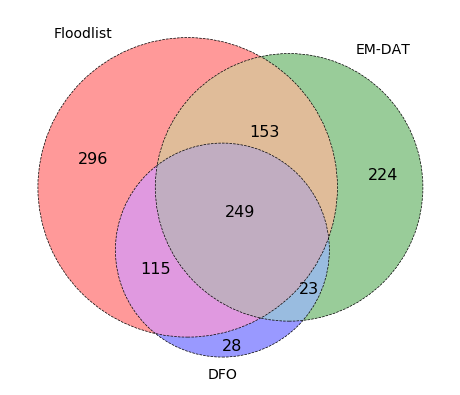

In [98]:
plt.figure(figsize=(8,8))
out = venn3(set_array[0:3], ('Floodlist', 'EM-DAT', 'DFO'))# venn3 works for three sets
c = venn3_circles(set_array[0:3], linestyle='dashed', linewidth=0.7)# venn3 works for three sets
for text in out.set_labels:
    text.set_fontsize(14)
for text in out.subset_labels:
    text.set_fontsize(16)

h = []
for i in a:
    h.append(out.get_patch_by_id(i))
    
plt.savefig('/Users/javirando/Desktop/Trabajo/Floods/Wikipedia/Paper/venn.png', format='png', dpi=200,  bbox_inches='tight')
plt.show()

In [93]:
merge2[['in_floodlist', 'in_EMS', 'in_EMDAT', 'in_darmouth']] =  merge2[['in_floodlist', 'in_EMS', 'in_EMDAT', 'in_darmouth']].fillna(0)
merge2['sources'] = merge2['in_floodlist'] + merge2['in_EMS'] + merge2['in_EMDAT'] + merge2['in_darmouth']

In [94]:
merge2 = merge2[merge2['sources']>1].reset_index(drop=True)

In [96]:
merge2.to_csv(".data/databases/merged_wikipedia.csv")